PRACTICAL LECTURE 4

PART1. Autoencoders

1. Import libraries

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

2. Convert vector to image
The following function allows to convert a vector to a image


In [2]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

3. We now write a function wchi allows to display the images using the omshow() function.

In [3]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

4. Define a data loading step and load the MNIST dataset

In [4]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('.\data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

5. Fix the used device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6. Define the Autoencoder model architecture and reconstruction loss
with : 
n = 28 x 28 = 784

A. Use d = 30  for standard AE (under-complete hidden layer)

B. Use d = 500 for denoising AE (over-complete hidden layer)

C. Explain the difference between standard AE and denoising AE.
Analyse the results and conclude.


In [6]:
d=30;

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

7. Configure the optimiser. We use here : learning_rate equals to 1e-3

In [7]:


learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

8. Train the standard autoencoder and the denoising autoencoder using the following code :


epoch [1/20], loss:0.1920
epoch [2/20], loss:0.1515
epoch [3/20], loss:0.1136
epoch [4/20], loss:0.1092
epoch [5/20], loss:0.0984
epoch [6/20], loss:0.0868
epoch [7/20], loss:0.0826
epoch [8/20], loss:0.0847
epoch [9/20], loss:0.0798
epoch [10/20], loss:0.0690
epoch [11/20], loss:0.0744
epoch [12/20], loss:0.0714
epoch [13/20], loss:0.0689
epoch [14/20], loss:0.0703
epoch [15/20], loss:0.0630
epoch [16/20], loss:0.0639
epoch [17/20], loss:0.0619
epoch [18/20], loss:0.0652
epoch [19/20], loss:0.0624
epoch [20/20], loss:0.0565


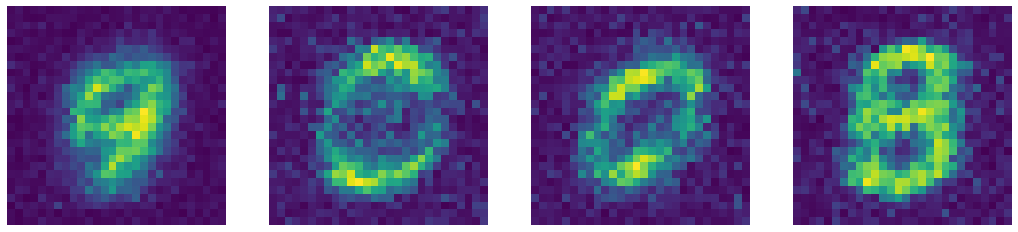

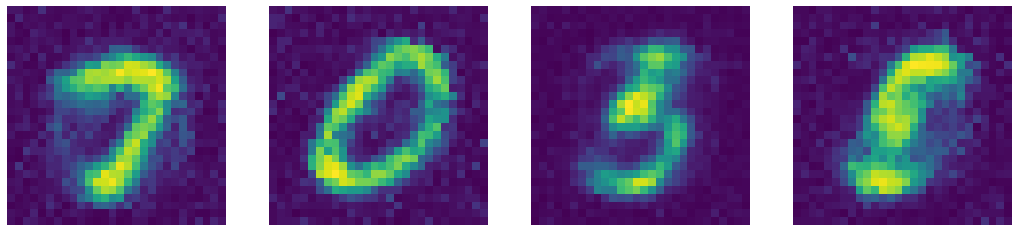

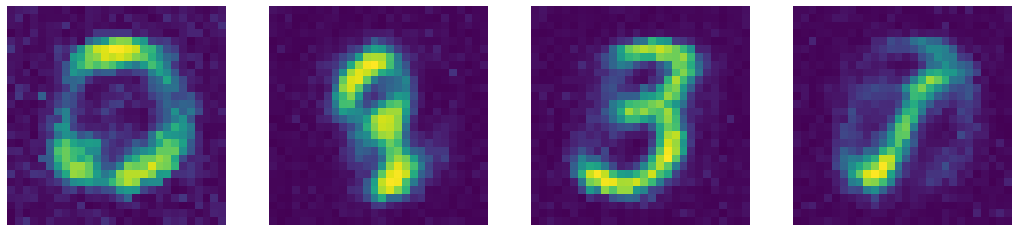

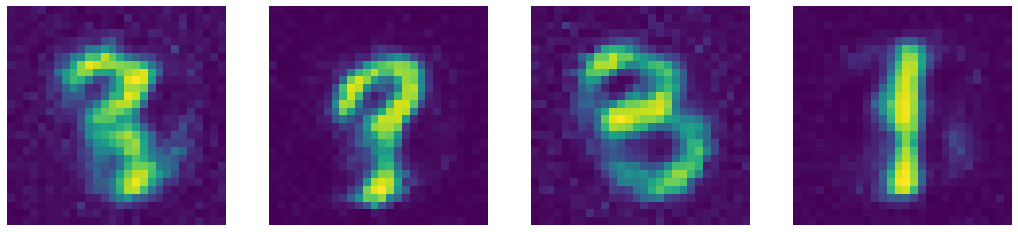

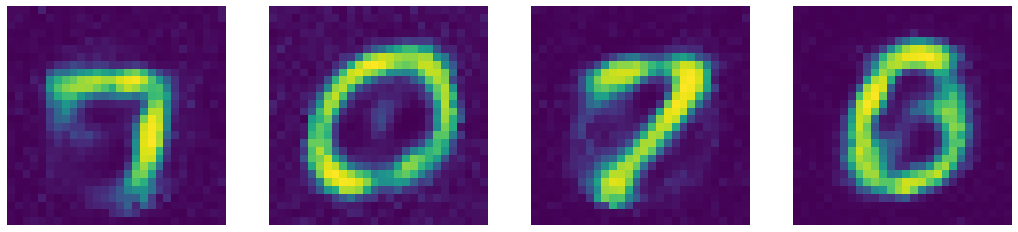

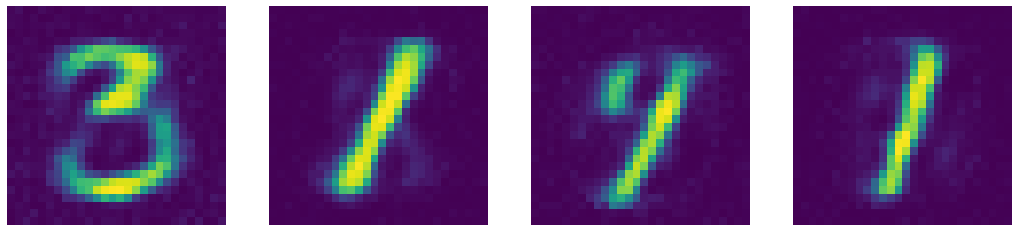

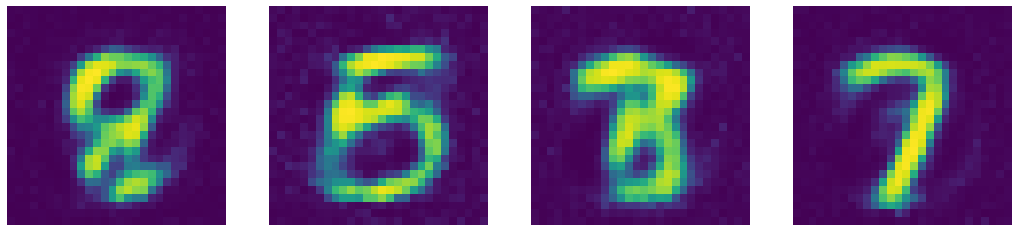

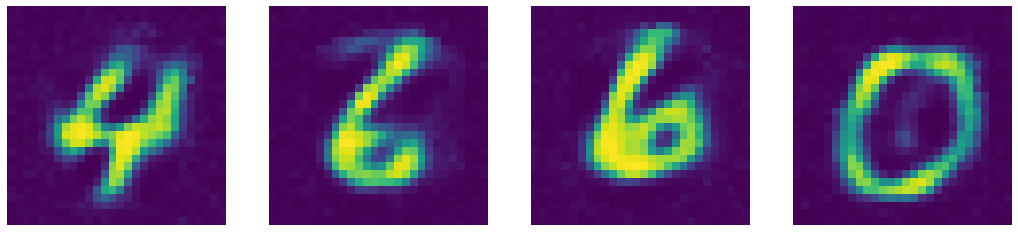

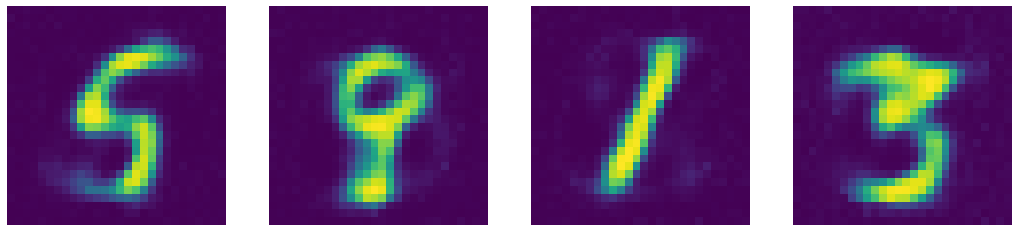

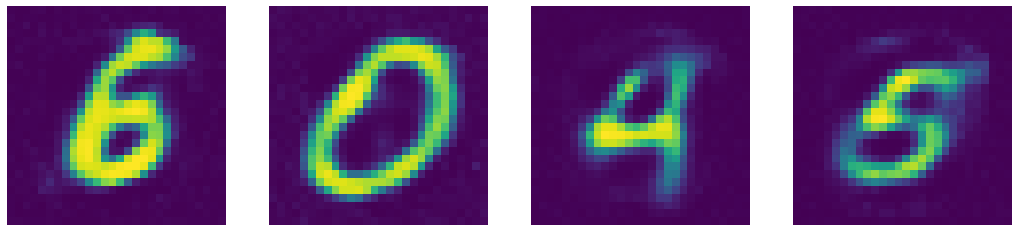

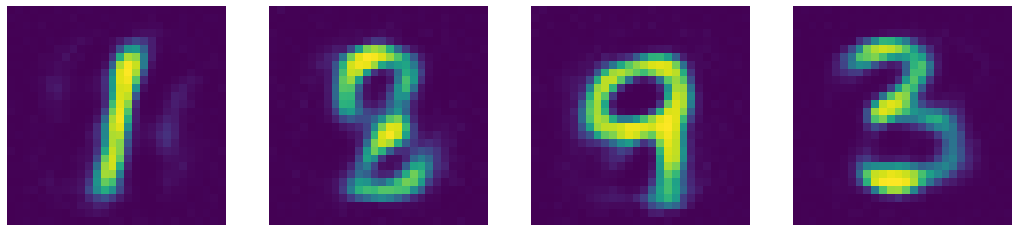

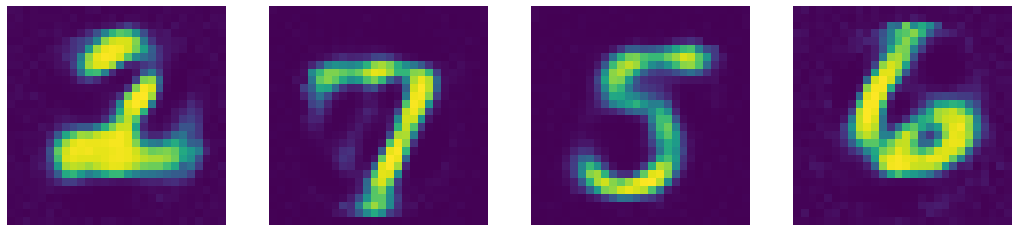

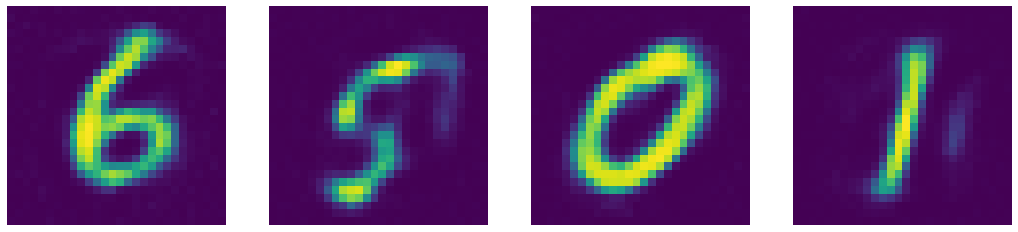

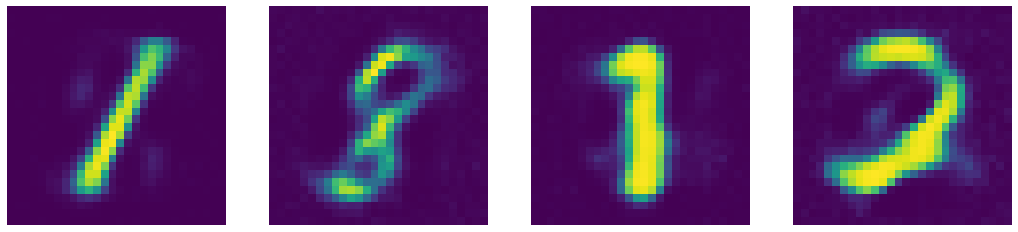

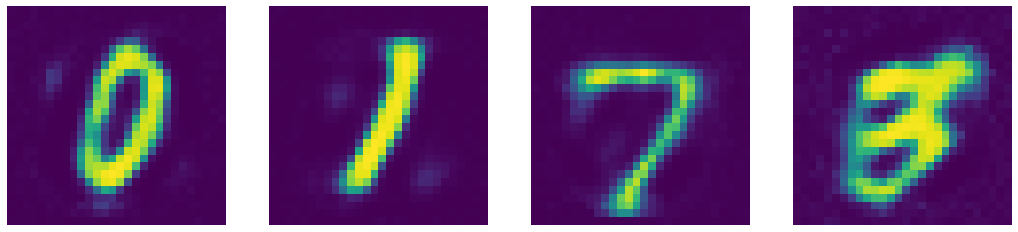

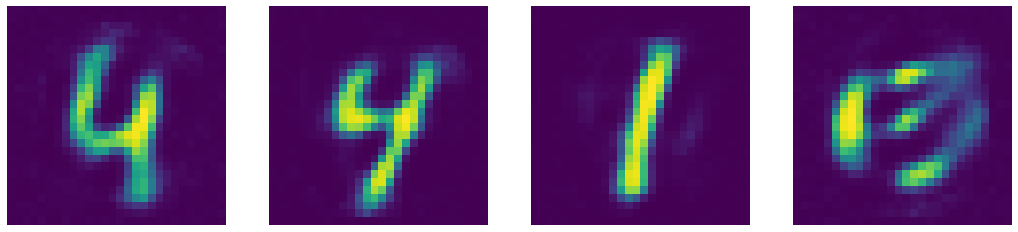

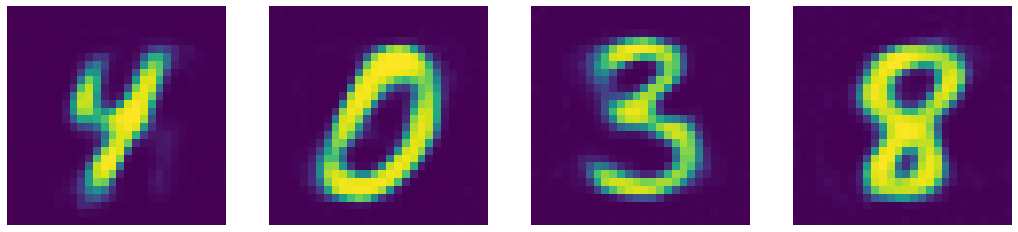

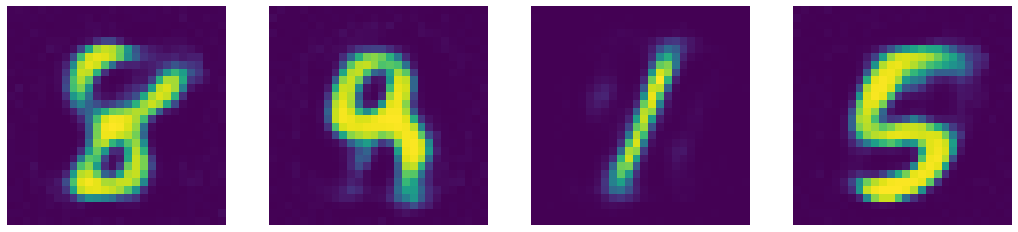

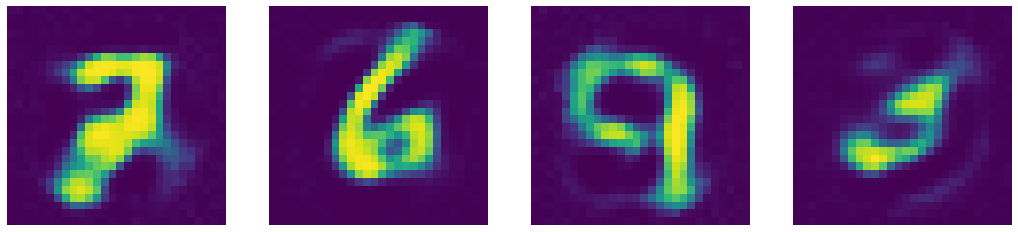

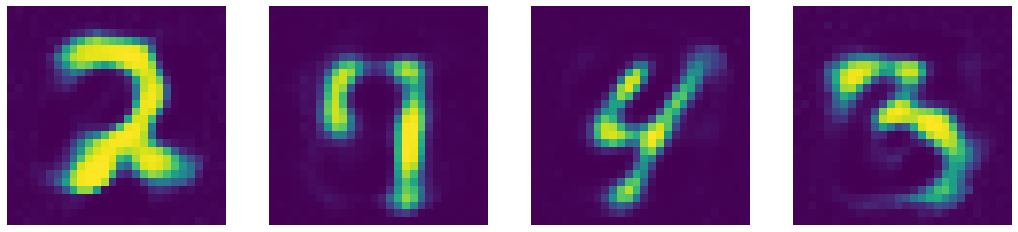

In [8]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

9. Visualise a few kernels of the encoder :


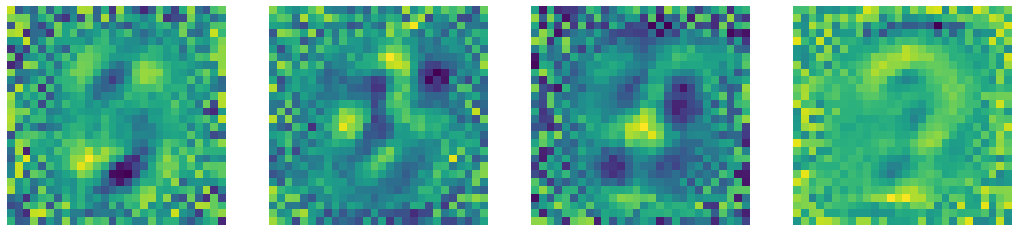

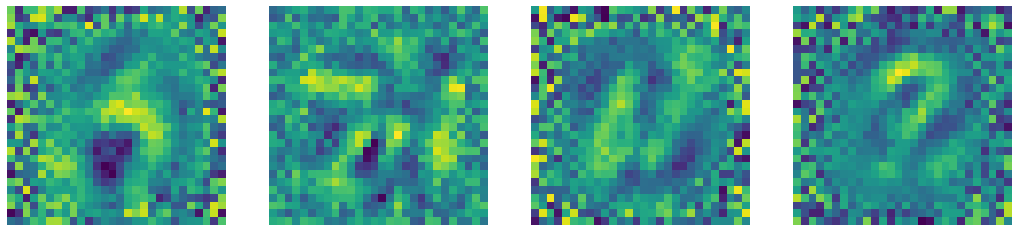

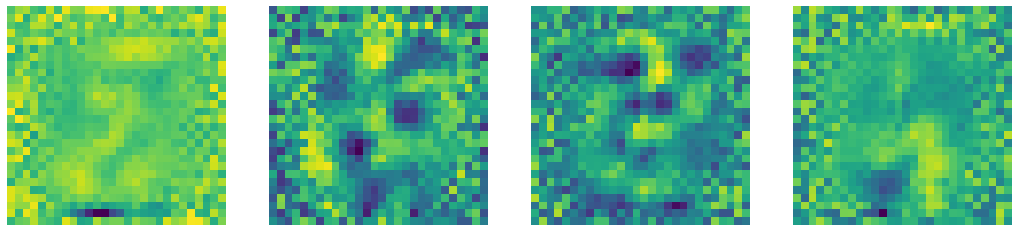

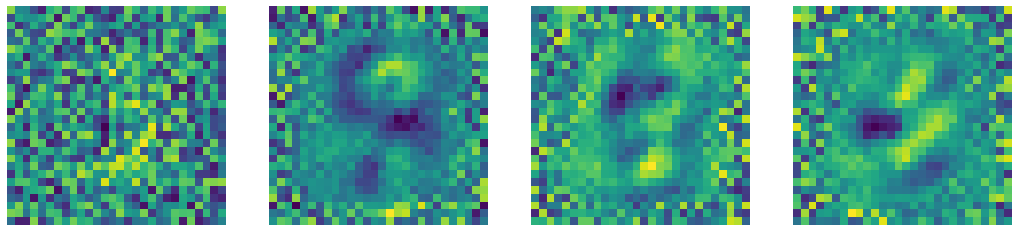

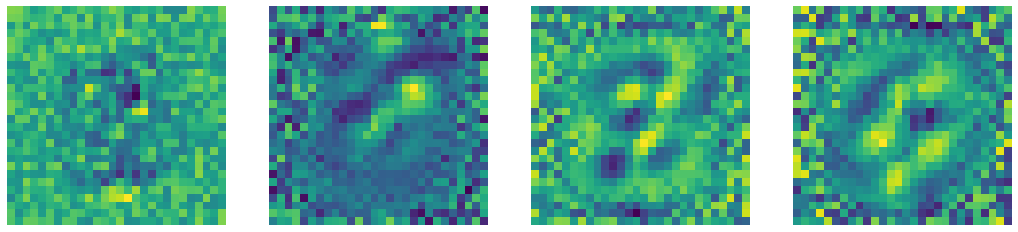

In [9]:
display_images(None, model.encoder[0].weight, 5)

10. Analyse the obtained results.
At first, the reconstructed images look nothing like the originals. Rather, the reconstructions look more like the average of some training images. As training progresses, our reconstructions are clearer.

11. Changes the parameters of the Autoencoder and analyse theirs impact. Conclude.

PART2. Convolutions Neural Networks

1. Import the librariries and set the parameters

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

set_default()

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2. Load the Dataset (MNIST) using PyTorch DataLoader utilities and visualize some images :


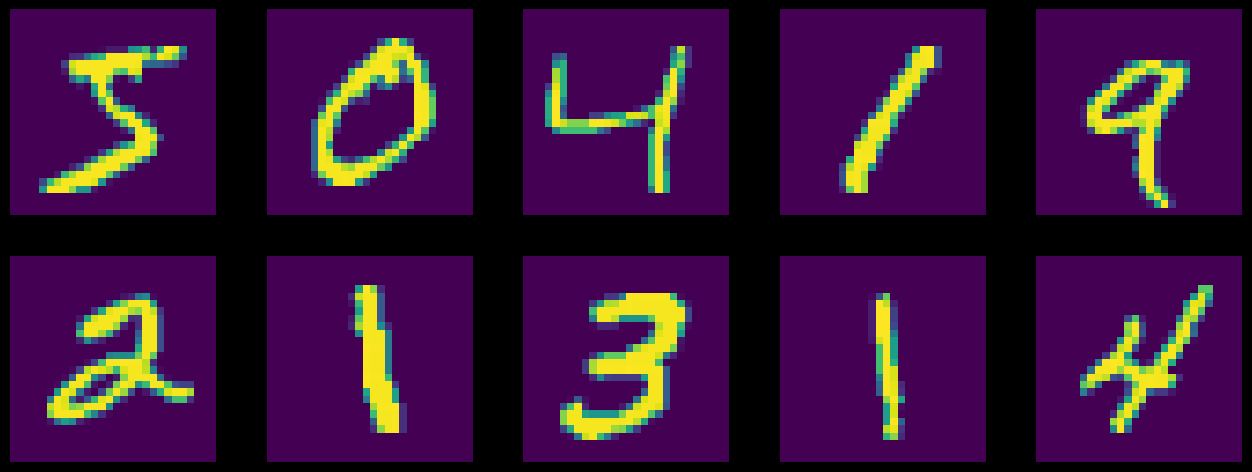

In [11]:

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');



3. Create the model classes




In [12]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

4. Run on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [13]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

5. Train a small fully-connected network

In [14]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.357651
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.963639
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.336848
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.012030
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.689913
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.686789
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.569742
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.768682
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.447108
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.613217

Test set: Average loss: 0.5707, Accuracy: 8085/10000 (81%)



6. Train a ConvNet with the same number of parameters

In [15]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.334080
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.882732
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.404248
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.414280
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.382898
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.418922
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.205122
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.284950
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.280092
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.111912

Test set: Average loss: 0.1535, Accuracy: 9534/10000 (95%)



7. Changes the parameters oof the model.

8. Analyze the results and the impact of these paremeters.